Interpretation de cluster par rapport au fire total--- et les metrique a consider pour voir chaque paramtre de algo  et surtot voir dbscan pour quoi il est pas adapter pour ce jour de probleme. le faite que il regoupe a chaque fois oon peux utiliser dbscan pour anomaly detection on dois interpreter les resultat de dbscan

# FROM SCRATCH DBSCAN

implémentation from scratch

Clusters détectés : [-1  1  2  3  4  5]
Silhouette Score : 0.9329
Dunn Index : 1.2670


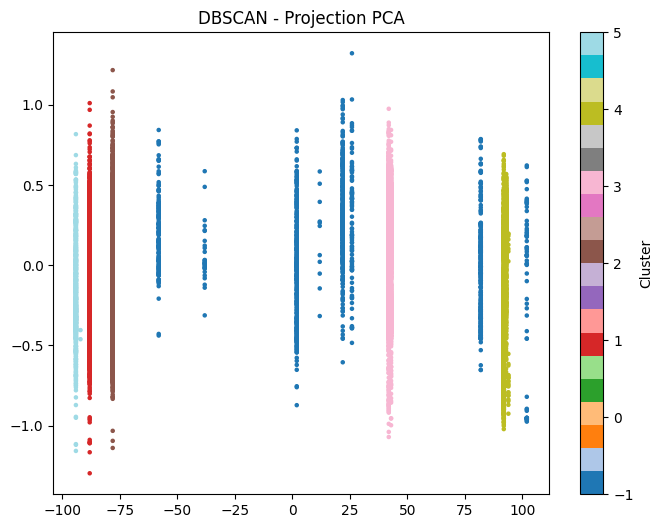

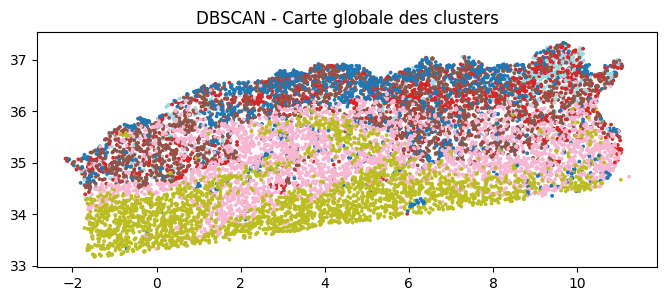

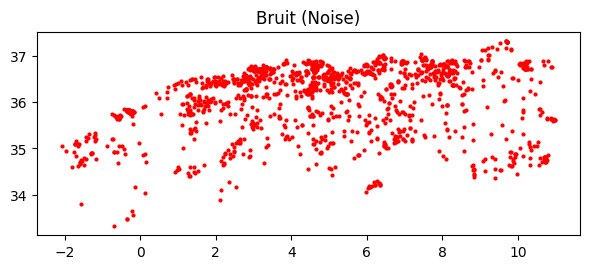

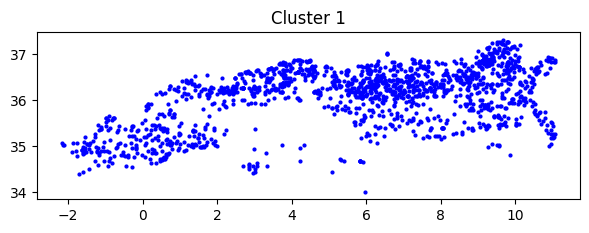

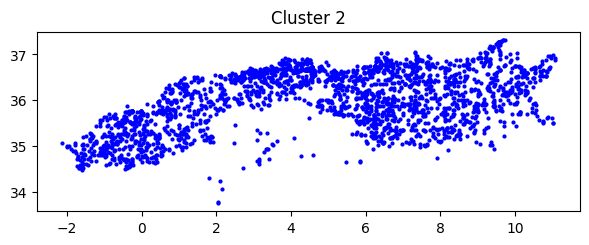

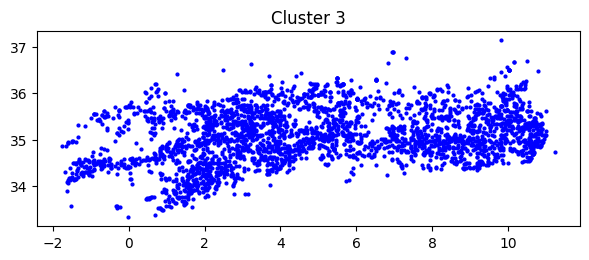

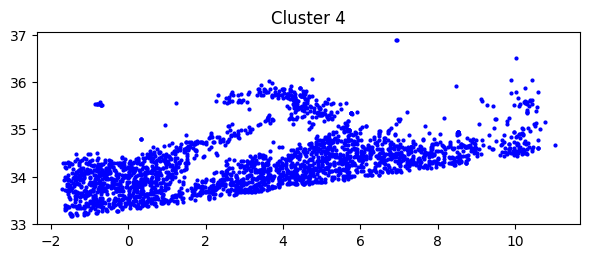

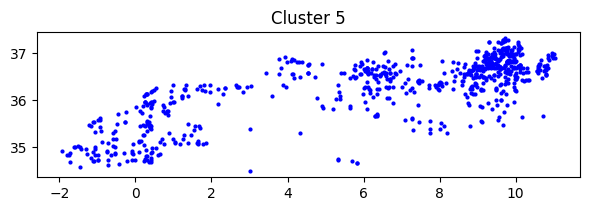

In [ ]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

# -----------------------------------------------------
# 1. Load dataset (GeoPackage)
# -----------------------------------------------------
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg")

X = gdf.drop(columns=['fire', gdf.geometry.name])
X_np = X.values

# -----------------------------------------------------
# 2. Custom Gower-like distance
# -----------------------------------------------------

def gower_distance(p1, p2, cat_index):
    """Compute numeric + categorical distance."""

    # numeric part
    num_distance = 0
    for i in range(len(p1)):
        if i != cat_index:
            num_distance += (p1[i] - p2[i]) ** 2
    num_distance = num_distance ** 0.5

    # categorical part
    cat_distance = 0 if p1[cat_index] == p2[cat_index] else 1

    # simplified Gower
    return (num_distance + cat_distance) / 2

# -----------------------------------------------------
# 3. Neighborhood search
# -----------------------------------------------------
def region_query(X, point_id, eps, cat_index):
    neighbors = []
    for i in range(len(X)):
        if gower_distance(X[point_id], X[i], cat_index) <= eps:
            neighbors.append(i)
    return neighbors

# -----------------------------------------------------
# 4. Expand cluster
# -----------------------------------------------------
def expand_cluster(X, labels, point_id, neighbors, cluster_id, eps, min_samples, cat_index):
    labels[point_id] = cluster_id
    i = 0
    while i < len(neighbors):
        n_id = neighbors[i]
        if labels[n_id] == -1:
            labels[n_id] = cluster_id
        elif labels[n_id] == 0:
            labels[n_id] = cluster_id
            new_neighbors = region_query(X, n_id, eps, cat_index)
            if len(new_neighbors) >= min_samples:
                neighbors += new_neighbors
        i += 1

# -----------------------------------------------------
# 5. DBSCAN
# -----------------------------------------------------
def dbscan(X, eps, min_samples, cat_index):
    labels = np.zeros(len(X), dtype=int)
    cluster_id = 0

    for i in range(len(X)):
        if labels[i] != 0:
            continue
        neighbors = region_query(X, i, eps, cat_index)
        if len(neighbors) < min_samples:
            labels[i] = -1
        else:
            cluster_id += 1
            expand_cluster(X, labels, i, neighbors,
                           cluster_id, eps, min_samples, cat_index)
    return labels

# -----------------------------------------------------
# 6. Run DBSCAN
# -----------------------------------------------------
eps = 1.5
min_samples = 450
cat_index = X_np.shape[1] - 1

y_pred = dbscan(X_np, eps, min_samples, cat_index)
gdf["cluster"] = y_pred

print("Clusters détectés :", np.unique(y_pred))

# -----------------------------------------------------
# 7. Silhouette Score (sans bruit)
# -----------------------------------------------------
mask = y_pred != -1
if len(np.unique(y_pred[mask])) > 1:
    sil_score = silhouette_score(X_np[mask], y_pred[mask])
    print(f"Silhouette Score : {sil_score:.4f}")
else:
    print("Silhouette Score : impossible (1 seul cluster)")

# -----------------------------------------------------
# 8. Dunn Index
# -----------------------------------------------------
def dunn_index(X, labels):
    clusters = [X[labels == c] for c in np.unique(labels) if c != -1]
    if len(clusters) < 2:
        return np.nan

    intra_dists = []
    for c in clusters:
        if len(c) > 1:
            intra_dists.append(np.max(cdist(c, c)))
    max_intra = np.max(intra_dists)

    inter_dists = []
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            inter_dists.append(np.min(cdist(clusters[i], clusters[j])))

    min_inter = np.min(inter_dists)
    return min_inter / max_intra

di = dunn_index(X_np, y_pred)
print(f"Dunn Index : {di:.4f}")

# -----------------------------------------------------
# 9. PCA Visualization
# -----------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred, s=5, cmap="tab20")
plt.title("DBSCAN - Projection PCA")
plt.colorbar(label="Cluster")
plt.show()

# -----------------------------------------------------
# 10. Carte globale
# -----------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(8,8))
gdf.plot(column="cluster", cmap="tab20", markersize=3, ax=ax)
ax.set_title("DBSCAN - Carte globale des clusters")
plt.show()

# -----------------------------------------------------
# 11. Carte par cluster
# -----------------------------------------------------
for c in np.unique(y_pred):
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    gdf[gdf["cluster"] == c].plot(
        ax=ax,
        markersize=4,
        color="red" if c == -1 else "blue"
    )
    title = "Bruit (Noise)" if c == -1 else f"Cluster {c}"
    ax.set_title(title)
    plt.show()


In [ ]:
# Sauvegarder
np.save("/content/drive/MyDrive/training_fire/clusters.npy", y_pred)

# Charger plus tard
y_pred_loaded = np.load("/content/drive/MyDrive/training_fire/clusters.npy")
gdf["cluster"] = y_pred_loaded


Carte des clusters de bruit et de feux effectifs

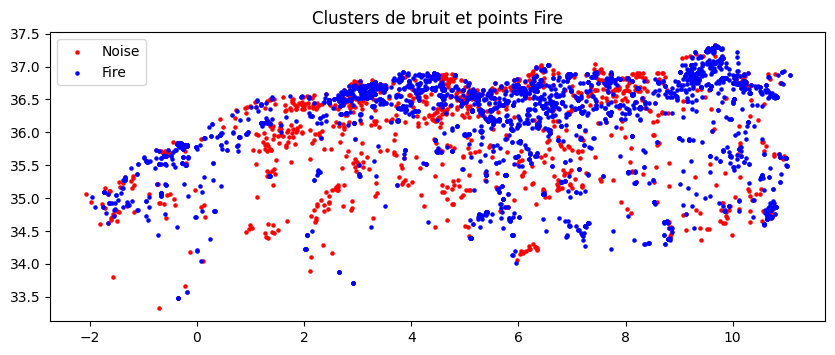

In [ ]:
import matplotlib.pyplot as plt

# Masque pour le bruit
mask_noise = gdf["cluster"] == -1

# Masque pour les points fire
mask_fire = gdf["fire"] == 1  # adapte si 'fire' = True ou 1

# Création de la figure
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Affichage du bruit
gdf[mask_noise].plot(
    ax=ax,
    color="red",
    markersize=5,
    label="Noise"
)

# Affichage des points fire
gdf[mask_fire].plot(
    ax=ax,
    color="blue",
    markersize=5,
    label="Fire"
)

# Titre et légende
ax.set_title("Clusters de bruit et points Fire")
ax.legend()
plt.show()


# SIKIT LEARN DBSCAN

implémentation sikitlearn

Clusters détectés : [-1  0  1  2  3  4]
Silhouette Score : 0.9330
Dunn Index : 1.8998


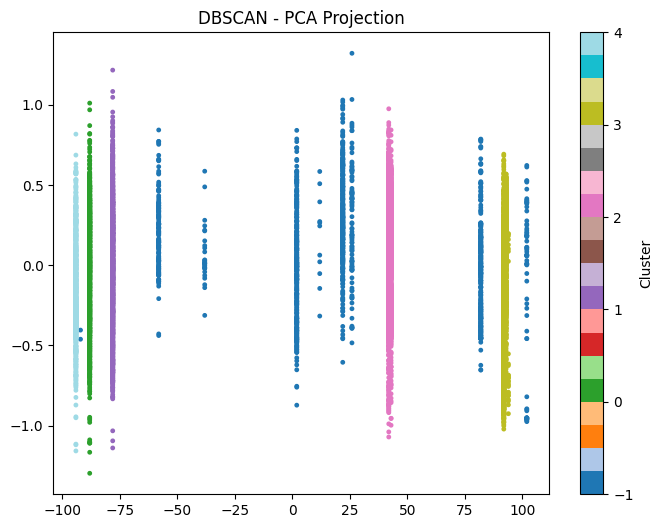

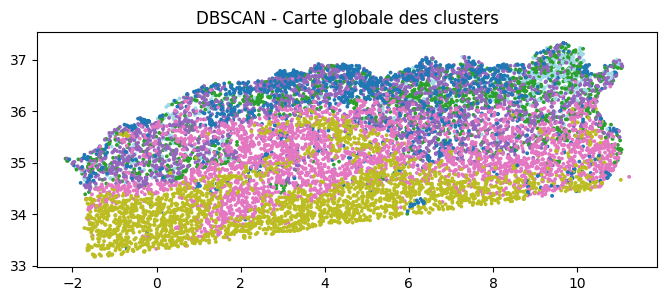

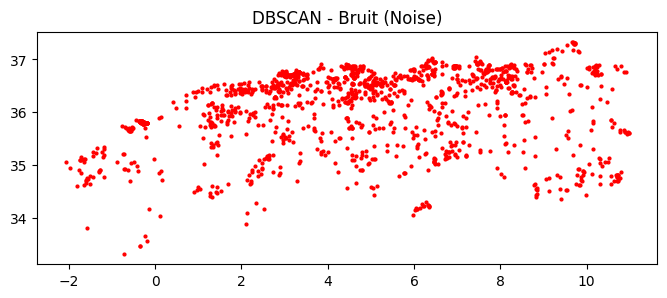

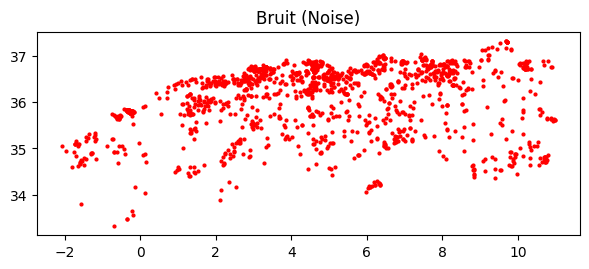

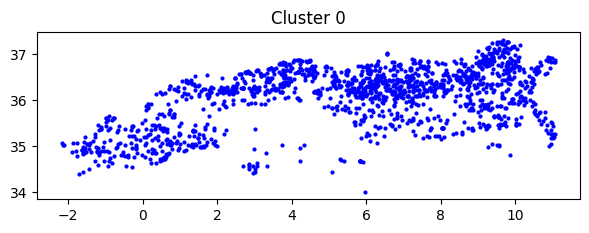

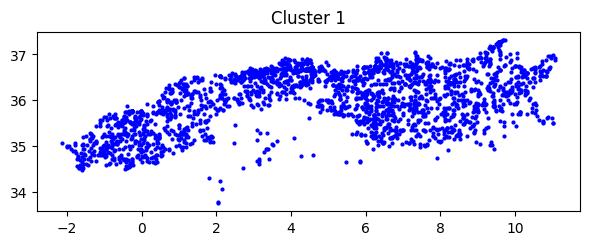

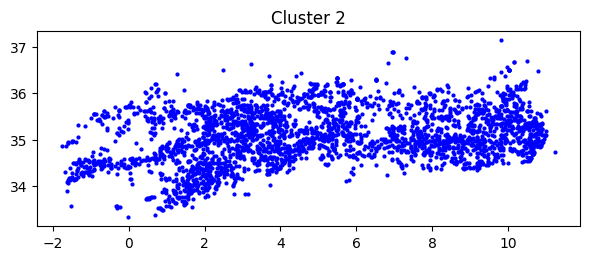

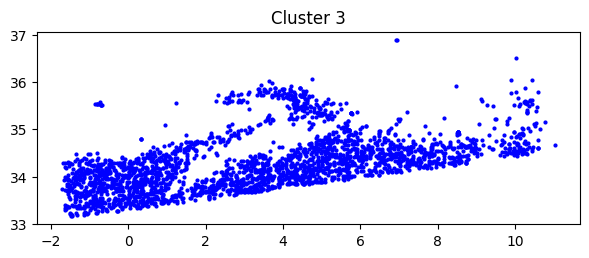

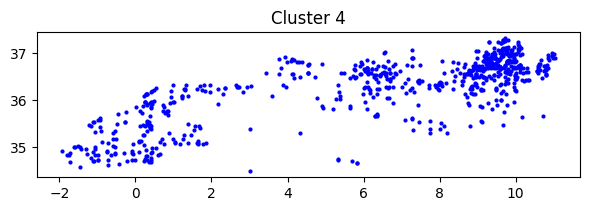

In [11]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

# =====================================================
# 1. Load data
# =====================================================
gdf = gpd.read_file(
    "/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg"
)

# -----------------------------------------------------
# 2. Keep ONLY numeric columns (CRITICAL)
# -----------------------------------------------------
X = gdf.drop(columns=[gdf.geometry.name], errors="ignore")
X = X.select_dtypes(include=[np.number])   # <-- FIX
X_np = X.values.astype(float)

# =====================================================
# 3. DBSCAN (NO normalization here)
# =====================================================
dbscan = DBSCAN(
    eps=2,          # adapté à ton dataset normalisé
    min_samples=450,
    metric="euclidean"
)

y_pred = dbscan.fit_predict(X_np)
gdf["cluster"] = y_pred

print("Clusters détectés :", np.unique(y_pred))

# =====================================================
# 4. Silhouette Score (sans bruit)
# =====================================================
mask = y_pred != -1
if len(np.unique(y_pred[mask])) > 1:
    sil = silhouette_score(X_np[mask], y_pred[mask])
    print(f"Silhouette Score : {sil:.4f}")
else:
    print("Silhouette Score : non calculable")

# =====================================================
# 5. Dunn Index
# =====================================================
def dunn_index(X, labels):
    clusters = [X[labels == c] for c in np.unique(labels) if c != -1]
    if len(clusters) < 2:
        return np.nan

    # max intra-cluster distance
    intra_dists = []
    for c in clusters:
        if len(c) > 1:
            intra_dists.append(np.max(cdist(c, c)))
    max_intra = np.max(intra_dists)

    # min inter-cluster distance
    inter_dists = []
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            inter_dists.append(np.min(cdist(clusters[i], clusters[j])))

    return np.min(inter_dists) / max_intra

di = dunn_index(X_np, y_pred)
print(f"Dunn Index : {di:.4f}")

# =====================================================
# 6. PCA visualization
# =====================================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred, cmap="tab20", s=6)
plt.colorbar(label="Cluster")
plt.title("DBSCAN - PCA Projection")
plt.show()

# =====================================================
# 7. Global map
# =====================================================
fig, ax = plt.subplots(1, 1, figsize=(8,8))
gdf.plot(column="cluster", cmap="tab20", markersize=3, ax=ax)
ax.set_title("DBSCAN - Carte globale des clusters")
plt.show()

# =====================================================
# 8. Noise map
# =====================================================
noise = gdf[gdf["cluster"] == -1]
if not noise.empty: # Add this check
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    noise.plot(color="red", markersize=4, ax=ax)
    ax.set_title("DBSCAN - Bruit (Noise)")
    plt.show()
else:

    print("No noise points detected to plot.")

# =====================================================
# 9. Map per cluster
# =====================================================
for c in np.unique(y_pred):
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    gdf[gdf["cluster"] == c].plot(
        ax=ax,
        markersize=4,
        color="red" if c == -1 else "blue"
    )
    ax.set_title("Bruit (Noise)" if c == -1 else f"Cluster {c}")
    plt.show()

In [12]:
# Sauvegarder
np.save("/content/drive/MyDrive/training_fire/clusters_sikit.npy", y_pred)

# Charger plus tard
y_pred_loaded = np.load("/content/drive/MyDrive/training_fire/clusters_sikit.npy")
gdf["cluster"] = y_pred_loaded

degré de risque des clusters performates

In [13]:
import numpy as np
import geopandas as gpd
import pandas as pd

# ===============================
# 1. Charger le GeoDataFrame
# ===============================
gdf = gpd.read_file(
    "/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg"
)

# ===============================
# 2. Charger les clusters
# ===============================
y_pred_loaded = np.load(
    "/content/drive/MyDrive/training_fire/clusters_sikit.npy"
)

# Ajouter les clusters au GeoDataFrame
gdf["cluster"] = y_pred_loaded

# ===============================
# 3. Vérification (optionnelle)
# ===============================
assert len(gdf) == len(y_pred_loaded), "Erreur : tailles incompatibles"

# ===============================
# 4. Calcul du nombre total de fire
# ===============================
# Hypothèse : fire = 1 (feu), 0 (non-feu)
total_fire = gdf["fire"].sum()

# ===============================
# 5. Statistiques par cluster
# ===============================
cluster_stats = (
    gdf
    .groupby("cluster")
    .agg(
        cluster_size=("fire", "count"),
        fire_count=("fire", "sum")
    )
)

# ===============================
# 6. Calcul des degrés de risque
# ===============================

# 1️⃣ Risque local : fire / taille du cluster
cluster_stats["risk_local"] = (
    cluster_stats["fire_count"] / cluster_stats["cluster_size"]
)

# 2️⃣ Risque global : fire / total des fire
cluster_stats["risk_global"] = (
    cluster_stats["fire_count"] / total_fire
)

# ===============================
# 7. Affichage
# ===============================
print(cluster_stats)


         cluster_size  fire_count  risk_local  risk_global
cluster                                                   
-1               1454         600    0.412655     0.228224
 0               1606         513    0.319427     0.195131
 1               2442         791    0.323915     0.300875
 2               3029         295    0.097392     0.112210
 3               2569         161    0.062670     0.061240
 4                729         269    0.368999     0.102320


# degré de risque des clusters moins performates

Clusters détectés : [-1  0  1  2  3  4  5  6  7  8  9 10 11]
Silhouette Score : 0.8958
Dunn Index : 1.2666


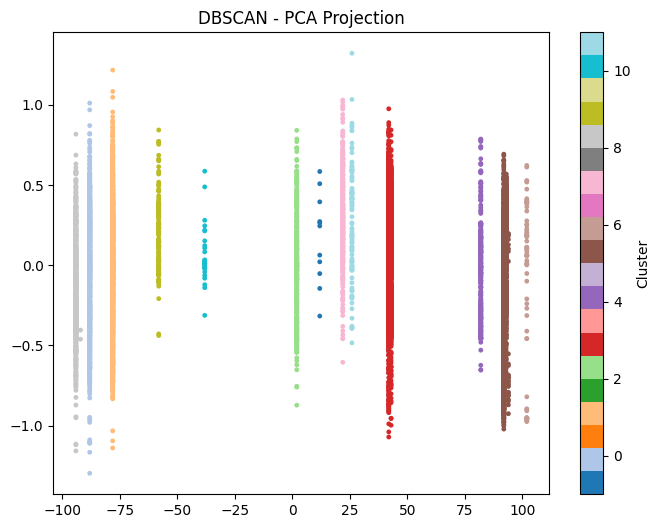

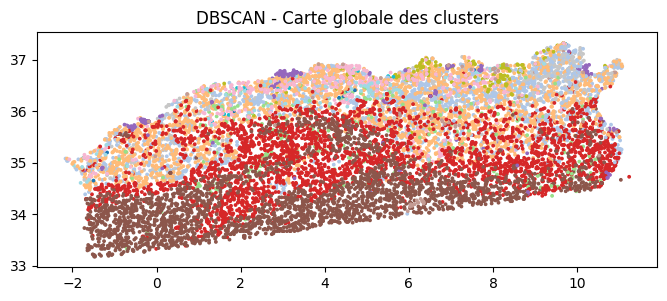

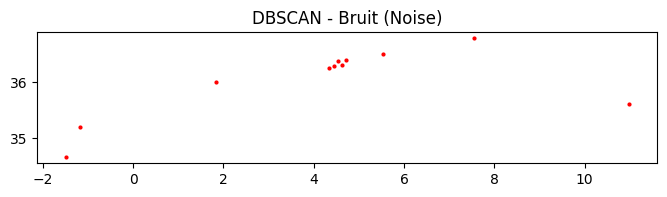

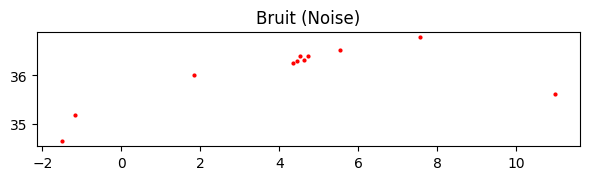

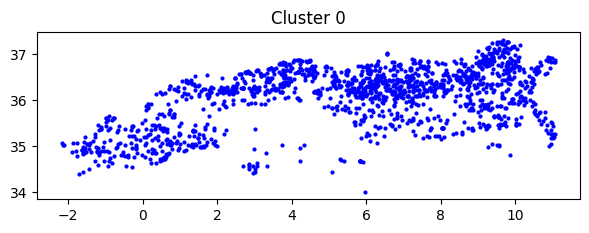

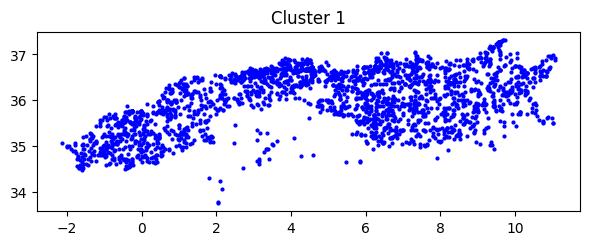

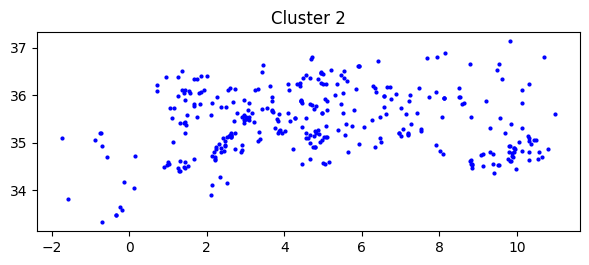

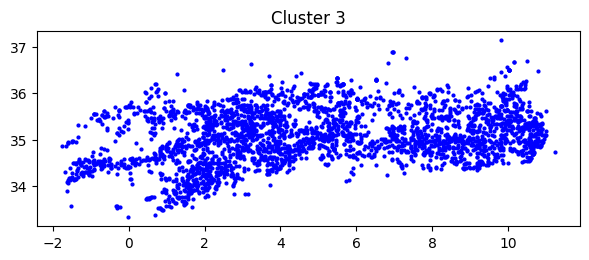

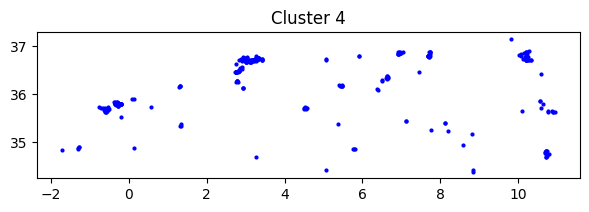

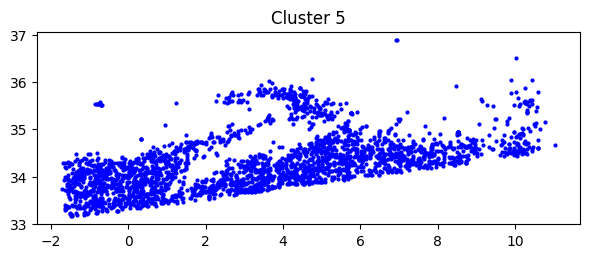

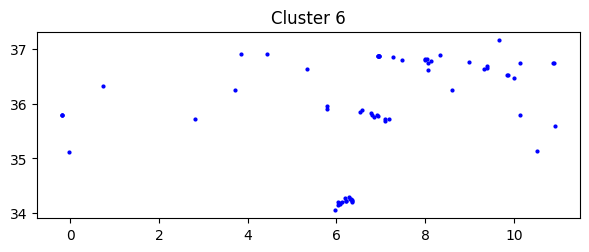

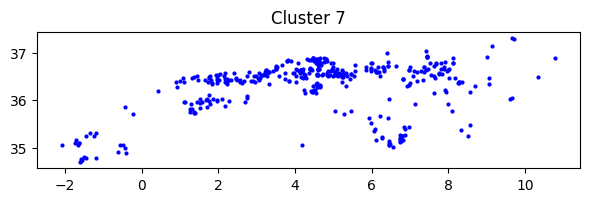

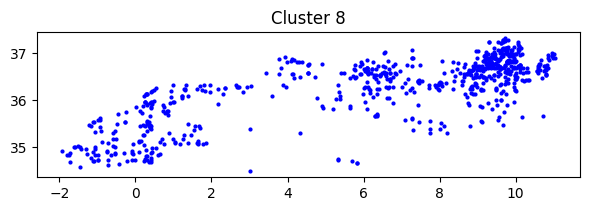

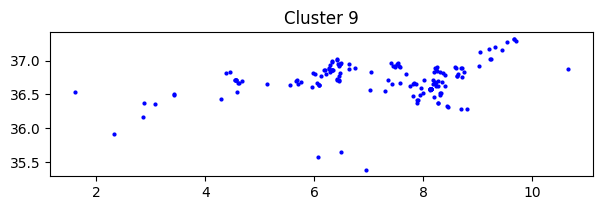

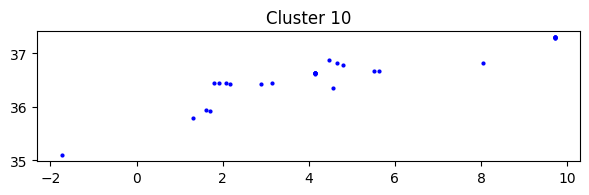

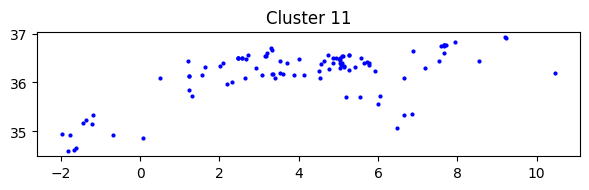

In [14]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

# =====================================================
# 1. Load data
# =====================================================
gdf = gpd.read_file(
    "/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg"
)

# -----------------------------------------------------
# 2. Keep ONLY numeric columns (CRITICAL)
# -----------------------------------------------------
X = gdf.drop(columns=[gdf.geometry.name], errors="ignore")
X = X.select_dtypes(include=[np.number])   # <-- FIX
X_np = X.values.astype(float)

# =====================================================
# 3. DBSCAN (NO normalization here)
# =====================================================
dbscan = DBSCAN(
    eps=3,          # adapté à ton dataset normalisé
    min_samples=25,
    metric="euclidean"
)

y_pred = dbscan.fit_predict(X_np)
gdf["cluster"] = y_pred

print("Clusters détectés :", np.unique(y_pred))

# =====================================================
# 4. Silhouette Score (sans bruit)
# =====================================================
mask = y_pred != -1
if len(np.unique(y_pred[mask])) > 1:
    sil = silhouette_score(X_np[mask], y_pred[mask])
    print(f"Silhouette Score : {sil:.4f}")
else:
    print("Silhouette Score : non calculable")

# =====================================================
# 5. Dunn Index
# =====================================================
def dunn_index(X, labels):
    clusters = [X[labels == c] for c in np.unique(labels) if c != -1]
    if len(clusters) < 2:
        return np.nan

    # max intra-cluster distance
    intra_dists = []
    for c in clusters:
        if len(c) > 1:
            intra_dists.append(np.max(cdist(c, c)))
    max_intra = np.max(intra_dists)

    # min inter-cluster distance
    inter_dists = []
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            inter_dists.append(np.min(cdist(clusters[i], clusters[j])))

    return np.min(inter_dists) / max_intra

di = dunn_index(X_np, y_pred)
print(f"Dunn Index : {di:.4f}")

# =====================================================
# 6. PCA visualization
# =====================================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred, cmap="tab20", s=6)
plt.colorbar(label="Cluster")
plt.title("DBSCAN - PCA Projection")
plt.show()

# =====================================================
# 7. Global map
# =====================================================
fig, ax = plt.subplots(1, 1, figsize=(8,8))
gdf.plot(column="cluster", cmap="tab20", markersize=3, ax=ax)
ax.set_title("DBSCAN - Carte globale des clusters")
plt.show()

# =====================================================
# 8. Noise map
# =====================================================
noise = gdf[gdf["cluster"] == -1]
if not noise.empty: # Add this check
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    noise.plot(color="red", markersize=4, ax=ax)
    ax.set_title("DBSCAN - Bruit (Noise)")
    plt.show()
else:

    print("No noise points detected to plot.")

# =====================================================
# 9. Map per cluster
# =====================================================
for c in np.unique(y_pred):
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    gdf[gdf["cluster"] == c].plot(
        ax=ax,
        markersize=4,
        color="red" if c == -1 else "blue"
    )
    ax.set_title("Bruit (Noise)" if c == -1 else f"Cluster {c}")
    plt.show()

In [16]:
# Sauvegarder
np.save("/content/drive/MyDrive/training_fire/clusters_sikit_mois.npy", y_pred)

# Charger plus tard
y_pred_loaded = np.load("/content/drive/MyDrive/training_fire/clusters_sikit_mois.npy")
gdf["cluster"] = y_pred_loaded

In [17]:
import numpy as np
import geopandas as gpd
import pandas as pd

# ===============================
# 1. Charger le GeoDataFrame
# ===============================
gdf = gpd.read_file(
    "/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg"
)

# ===============================
# 2. Charger les clusters
# ===============================
y_pred_loaded = np.load(
    "/content/drive/MyDrive/training_fire/clusters_sikit_mois.npy"
)

# Ajouter les clusters au GeoDataFrame
gdf["cluster"] = y_pred_loaded

# ===============================
# 3. Vérification (optionnelle)
# ===============================
assert len(gdf) == len(y_pred_loaded), "Erreur : tailles incompatibles"

# ===============================
# 4. Calcul du nombre total de fire
# ===============================
# Hypothèse : fire = 1 (feu), 0 (non-feu)
total_fire = gdf["fire"].sum()

# ===============================
# 5. Statistiques par cluster
# ===============================
cluster_stats = (
    gdf
    .groupby("cluster")
    .agg(
        cluster_size=("fire", "count"),
        fire_count=("fire", "sum")
    )
)

# ===============================
# 6. Calcul des degrés de risque
# ===============================

# 1️⃣ Risque local : fire / taille du cluster
cluster_stats["risk_local"] = (
    cluster_stats["fire_count"] / cluster_stats["cluster_size"]
)

# 2️⃣ Risque global : fire / total des fire
cluster_stats["risk_global"] = (
    cluster_stats["fire_count"] / total_fire
)

# ===============================
# 7. Affichage
# ===============================
print(cluster_stats)


         cluster_size  fire_count  risk_local  risk_global
cluster                                                   
-1                 11           2    0.181818     0.000761
 0               1606         513    0.319427     0.195131
 1               2442         791    0.323915     0.300875
 2                339          48    0.141593     0.018258
 3               3029         295    0.097392     0.112210
 4                317         239    0.753943     0.090909
 5               2569         161    0.062670     0.061240
 6                 67          18    0.268657     0.006847
 7                426         169    0.396714     0.064283
 8                731         270    0.369357     0.102701
 9                161          65    0.403727     0.024724
 10                30          16    0.533333     0.006086
 11               101          42    0.415842     0.015976
